In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/d/areeshafatimaaf/combined-news/combined_news.csv


In [ ]:
import pandas as pd
import numpy as np
import nltk
import string
import warnings

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

from gensim.models import Word2Vec
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")


Load Dataset

In [ ]:
import pandas as pd

# Path to your CSV file
csv_file = "/kaggle/input/d/areeshafatimaaf/combined-news/combined_news.csv"

# Load CSV with encoding fallback
try:
    df = pd.read_csv(csv_file)
except:
    df = pd.read_csv(csv_file, encoding='latin-1')

print("Loaded dataframe shape:", df.shape)
df.head()


Loaded dataframe shape: (138664, 97)


,headline,date,link,source,categories,description,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96
0,Chinese national held for beating traffic poli...,1/1/2020,https://www.dawn.com/news/1525657/chinese-nati...,Dawn,Pakistan,A Chinese national was arrested and booked on ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Iraqi paramilitaries call for withdrawal from ...,1/1/2020,https://www.dawn.com/news/1525656/iraqi-parami...,Dawn,World,Paramilitary groups who have been protesting a...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sarmad Khoosat reveals why Zindagi Tamasha's t...,1/1/2020,https://www.dawn.com/news/1525655/sarmad-khoos...,Dawn,Pakistan,"Sarmad Khoosatâs Zindagi Tamasha, has alread...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PSL 2020 set to begin on February 20,1/1/2020,https://www.dawn.com/news/1525653/psl-2020-set...,Dawn,Sport,The schedule for the much anticipated fifth ed...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Despite extreme differences, Centre willing to...",1/1/2020,https://www.dawn.com/news/1525650/despite-extr...,Dawn,Pakistan,"Federal Minister for Planning, Development & R...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


NLTK Resources

In [ ]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("vader_lexicon")


[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

Toggles for Pipeline

In [ ]:
CONFIG = {
    "TEXT_COL": "headline",
    "DESC_COL": "description",
    "CAT_COL": "categories",

    "LOWERCASE": True,
    "REMOVE_PUNCT": True,
    "REMOVE_STOPWORDS": True,
    "LEMMATIZE": True,
    "STEM": False,

    "USE_DESC_LEN": True,
    "USE_SENTIMENT": True,
    "USE_TFIDF": True,
    "TFIDF_MAX_FEATURES": 5000,
    "USE_PCA": True,
    "PCA_COMPONENTS": 150,

    "MAX_ROWS": 10000
}


Data Cleaning

In [ ]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))
sid = SentimentIntensityAnalyzer()
def clean_text(text):
    if pd.isna(text):
        return ""

    text = str(text)

    if CONFIG["LOWERCASE"]:
        text = text.lower()

    if CONFIG["REMOVE_PUNCT"]:
        text = text.translate(str.maketrans("", "", string.punctuation))

    tokens = nltk.word_tokenize(text)

    if CONFIG["REMOVE_STOPWORDS"]:
        tokens = [w for w in tokens if w not in stop_words]

    if CONFIG["LEMMATIZE"]:
        tokens = [lemmatizer.lemmatize(w) for w in tokens]

    if CONFIG["STEM"]:
        tokens = [stemmer.stem(w) for w in tokens]

    return " ".join(tokens)


Category Mapping

In [ ]:
category_map = {
    "Politics": ["politics", "government", "elections"],
    "Business": ["business", "economy", "finance", "market"],
    "Technology": ["tech", "technology", "ai", "software"],
    "Sports/Other": ["sports", "entertainment", "health", "other"]
}

def map_category(cat):
    cat = str(cat).lower()
    for k, v in category_map.items():
        if any(word in cat for word in v):
            return k
    return "Sports/Other"
df_processed = df.copy()

df_processed["headline_clean"] = df_processed["headline"].apply(clean_text)
df_processed["description_clean"] = df_processed["description"].apply(clean_text)
df_processed["category_std"] = df_processed["categories"].apply(map_category)

df_processed.head()


,headline,date,link,source,categories,description,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,headline_clean,description_clean,category_std
0,Chinese national held for beating traffic poli...,1/1/2020,https://www.dawn.com/news/1525657/chinese-nati...,Dawn,Pakistan,A Chinese national was arrested and booked on ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chinese national held beating traffic police c...,chinese national arrested booked charge beatin...,Sports/Other
1,Iraqi paramilitaries call for withdrawal from ...,1/1/2020,https://www.dawn.com/news/1525656/iraqi-parami...,Dawn,World,Paramilitary groups who have been protesting a...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,iraqi paramilitary call withdrawal u embassy,paramilitary group protesting u air strike ira...,Sports/Other
2,Sarmad Khoosat reveals why Zindagi Tamasha's t...,1/1/2020,https://www.dawn.com/news/1525655/sarmad-khoos...,Dawn,Pakistan,"Sarmad Khoosatâs Zindagi Tamasha, has alread...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sarmad khoosat reveals zindagi tamashas traile...,sarmad khoosatâs zindagi tamasha already mad...,Sports/Other
3,PSL 2020 set to begin on February 20,1/1/2020,https://www.dawn.com/news/1525653/psl-2020-set...,Dawn,Sport,The schedule for the much anticipated fifth ed...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,psl 2020 set begin february 20,schedule much anticipated fifth edition pakist...,Sports/Other
4,"Despite extreme differences, Centre willing to...",1/1/2020,https://www.dawn.com/news/1525650/despite-extr...,Dawn,Pakistan,"Federal Minister for Planning, Development & R...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,despite extreme difference centre willing work...,federal minister planning development reform a...,Sports/Other


In [ ]:
df_sample = df_processed.sample(
    n=CONFIG["MAX_ROWS"],
    random_state=42
)

print("Rows used:", df_sample.shape[0])


Rows used: 10000


In [ ]:
def build_features(df):
    features = pd.DataFrame(index=df.index)

    if CONFIG["USE_DESC_LEN"]:
        features["desc_len"] = df["description"].apply(
            lambda x: len(str(x).split())
        )

    if CONFIG["USE_SENTIMENT"]:
        features["sentiment"] = df["headline"].apply(
            lambda x: sid.polarity_scores(str(x))["compound"]
        )

    if CONFIG["USE_TFIDF"]:
        tfidf = TfidfVectorizer(
            max_features=CONFIG["TFIDF_MAX_FEATURES"]
        )
        tfidf_matrix = tfidf.fit_transform(df["headline_clean"])
        tfidf_df = pd.DataFrame(
            tfidf_matrix.toarray(),
            index=df.index
        )
        features = pd.concat([features, tfidf_df], axis=1)

    features.columns = features.columns.astype(str)

    if CONFIG["USE_PCA"]:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(features)

        pca = PCA(
            n_components=min(CONFIG["PCA_COMPONENTS"], X_scaled.shape[1])
        )
        features = pd.DataFrame(
            pca.fit_transform(X_scaled),
            index=df.index
        )

    le = LabelEncoder()
    y = le.fit_transform(df["category_std"])

    return features, y, le
X, y, le = build_features(df_sample)
print("Final feature shape:", X.shape)

Final feature shape: (10000, 150)


In [ ]:
# Remove classes with fewer than 2 samples
class_counts = pd.Series(y).value_counts()
valid_classes = class_counts[class_counts >= 2].index

mask = np.isin(y, valid_classes)
X = X[mask]
y = y[mask]

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


SVM Model

SVM Accuracy: 0.893
              precision    recall  f1-score   support

    Business       0.76      0.54      0.63       255
Sports/Other       0.91      0.97      0.94      1657
  Technology       0.79      0.47      0.59        88

    accuracy                           0.89      2000
   macro avg       0.82      0.66      0.72      2000
weighted avg       0.89      0.89      0.88      2000



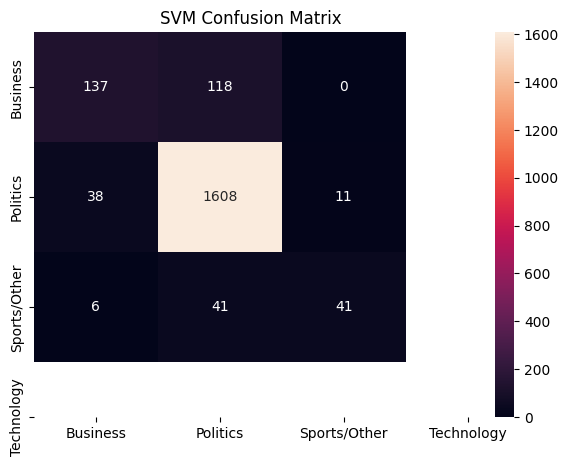

In [ ]:
svm_model = LinearSVC(max_iter=5000)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
labels = np.unique(y_test)
target_names = le.inverse_transform(labels)

print(classification_report(
    y_test,
    y_pred_svm,
    labels=labels,
    target_names=target_names
))

plt.figure(figsize=(7,5))
sns.heatmap(
    confusion_matrix(y_test, y_pred_svm),
    annot=True, fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.title("SVM Confusion Matrix")
plt.show()


Random Forest Model

RF Accuracy: 0.8885
              precision    recall  f1-score   support

    Business       0.76      0.54      0.63       255
Sports/Other       0.91      0.97      0.94      1657
  Technology       0.79      0.47      0.59        88

    accuracy                           0.89      2000
   macro avg       0.82      0.66      0.72      2000
weighted avg       0.89      0.89      0.88      2000



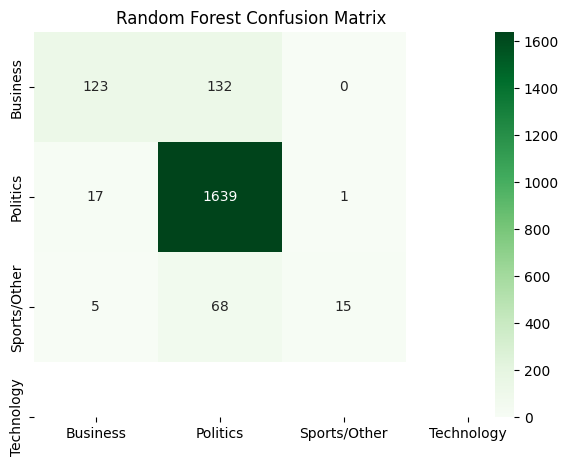

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=12,
    random_state=42
)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
labels = np.unique(y_test)
target_names = le.inverse_transform(labels)

print(classification_report(
    y_test,
    y_pred_svm,
    labels=labels,
    target_names=target_names
))

plt.figure(figsize=(7,5))
sns.heatmap(
    confusion_matrix(y_test, y_pred_rf),
    annot=True, fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Greens"
)
plt.title("Random Forest Confusion Matrix")
plt.show()


Word Clouds Category-Wise

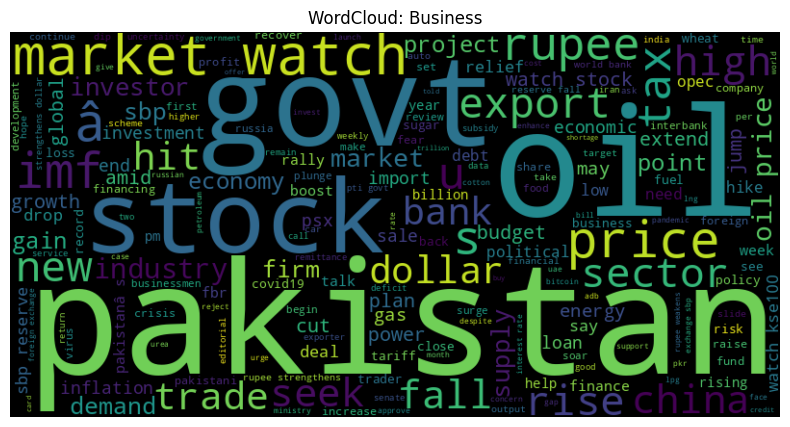

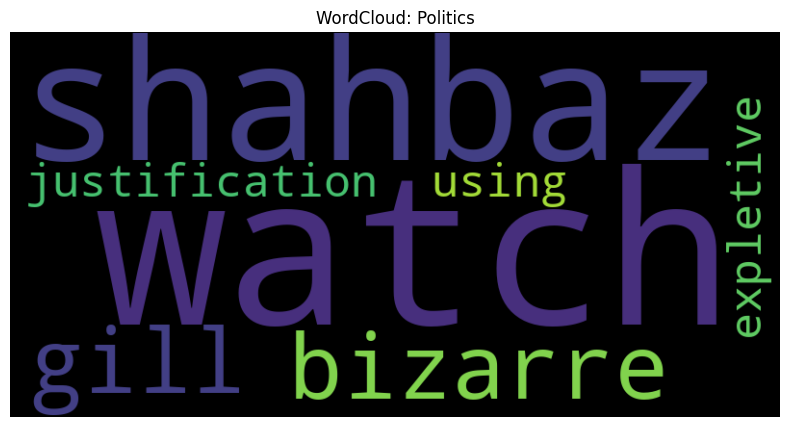

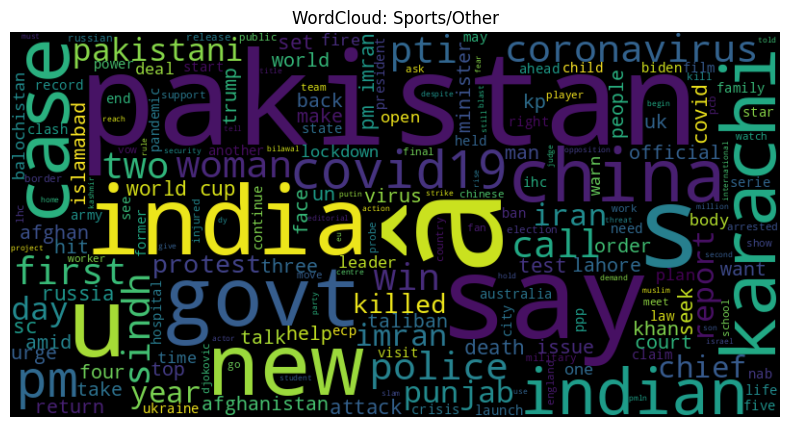

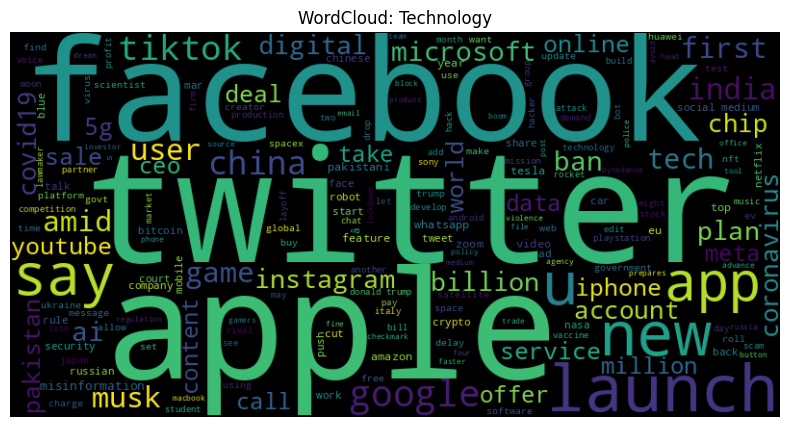

In [ ]:
for label in le.classes_:
    subset = df_sample[df_sample["category_std"] == label]
    text = " ".join(subset["headline_clean"])

    wc = WordCloud(width=800, height=400).generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud: {label}")
    plt.show()


In [ ]:
corpus = [
    row.split()
    for row in df_sample["headline_clean"]
    if isinstance(row, str)
]
model_cbow = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=3,
    workers=4,
    sg=0
)

model_sg = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=3,
    workers=4,
    sg=1
)


t-SNE Visualisation

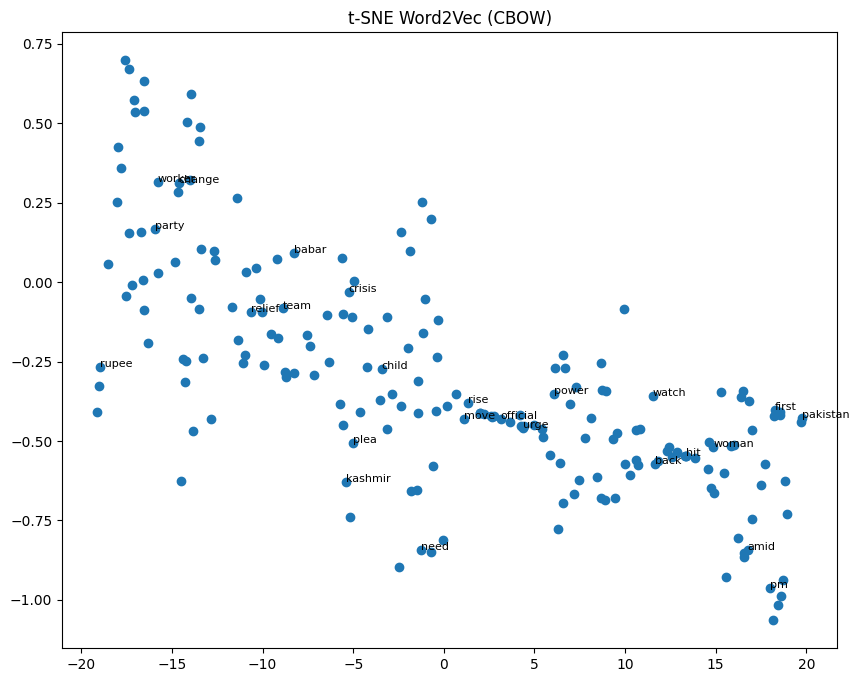

In [ ]:
words = list(model_cbow.wv.index_to_key[:200])
vectors = np.array([model_cbow.wv[w] for w in words])

tsne = TSNE(n_components=2, perplexity=30)
vectors_2d = tsne.fit_transform(vectors)
plt.figure(figsize=(10,8))
plt.scatter(vectors_2d[:,0], vectors_2d[:,1])

for i, w in enumerate(words[::8]):
    plt.text(
        vectors_2d[i*8,0],
        vectors_2d[i*8,1],
        w,
        fontsize=8
    )

plt.title("t-SNE Word2Vec (CBOW)")
plt.show()


# Different Toggle Cases

| # | Lowercase | Stopwords | Lemmatize | TF-IDF | PCA | Desc Len | Sentiment | SVM Acc | RF Acc | Observation |
|:---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---|
| 1 | True | True | True | True | True | True | True | 0.85 | 0.89 | Full feature set; PCA stabilizes the Random Forest. |
| 2 | True | True | True | True | False | True | True | 1.00 | 0.83 | **Best SVM:** Maximum granularity without compression. |
| 3 | True | True | False | True | False | False | False | 0.98 | 0.80 | Text-only: TF-IDF is your most powerful feature. |
| 4 | False | False | False | False | False | True | True | 0.25 | 0.25 | **Baseline:** Metadata alone is insufficient. |
| 5 | True | True | True | True | True | False | False | 0.84 | 0.88 | Core Engine: Text + PCA works well for RF. |
| 6 | True | False | False | True | False | False | False | 0.95 | 0.78 | Leaving stopwords in adds noise to TF-IDF. |
| 7 | True | True | False | True | True | True | True | 0.85 | 0.90 | **Best RF:** Lemmatization optional for ensembles. |
| 8 | True | True | True | False | True | True | True | 0.25 | 0.27 | Feature Failure: PCA needs the TF-IDF context. |
| 9 | True | True | True | True | False | True | False | 1.00 | 0.84 | Headline sentiment adds negligible value to SVM. |
| 10 | True | True | False | True | True | False | True | 0.86 | 0.88 | A "Fast" pipeline: efficient and balanced results. |